---
# Contents
- Dataloader
- Implementation
- Train
- Ranking Metrics
- Evaluation
- Test
- Prediction
- Case Study
- Reference

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt

from numba import njit
from scipy.sparse import csr_matrix, dok_matrix
from collections import defaultdict, Counter
from itertools import islice

from tqdm import trange
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score

In this intern project, I apply **ALS** based matrix factorization in **collaborative filtering** for **implicit** feedback Walmart.com user-item transaction dataset to implement a user response based and personalized ranking recommendation system for future customers.

---
# Dataloader

Read queried files from output of `preprocess.ipynb` and convert into sparse matrix.

In [2]:
# read preprocessed train file
file_path = '../Data/processed_train.txt'
names = ['userId', 'itemId', 'rating']
df = pd.read_csv(file_path, sep='\t', header=None, names=names)

print('train dimension:', df.shape)
df.head()

train dimension: (1180452, 3)


,userId,itemId,rating
0,0,0,1
1,0,26,1
2,0,945,1
3,0,1244,1
4,0,1752,1


In [3]:
# convert raw data to sparse user-item matrix
def create_matrix(data, user_col, item_col, rating_col):
    """
    rtype: scipy sparse matrix csr_matrix, [n_users, n_items]
    """
    for col in (item_col, user_col):
        data[col] = data[col].astype('category')
    
    rows = data[user_col].cat.codes
    cols = data[item_col].cat.codes
    ratings = csr_matrix((data[rating_col], (rows, cols)))
    ratings.eliminate_zeros()
    
    return ratings, data

In [4]:
X_train, df = create_matrix(df, 'userId', 'itemId', 'rating')
X_train

<34619x47880 sparse matrix of type '<class 'numpy.int64'>'
	with 1180452 stored elements in Compressed Sparse Row format>

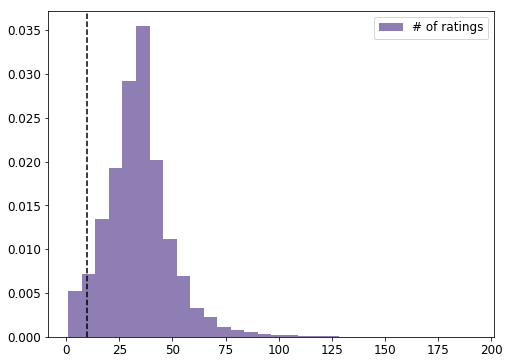

In [5]:
# visualize
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12
plt.hist(np.sum(X_train != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6', density = True)
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()
plt.close()

In [ ]:
# split matrix into training and test parts
## based on user vectors and same time scale
def create_train_validation(ratings, validation_size, seed=None):
    """
    rtype: two scipy sparse csr_matrices
    """
    training = ratings.copy().todok()
    validation = dok_matrix(training.shape)
    
    rstate = np.random.RandomState(seed)
    
    for user in range(ratings.shape[0]):
        split_index = ratings[user].indices
        n_splits = math.ceil(validation_size * len(split_index))
        validation_index = rstate.choice(split_index, size=n_splits, replace=False)
        validation[user, validation_index] = ratings[user, validation_index]
        training[user, validation_index] = 0
    
    training, validation = training.tocsr(), validation.tocsr()
    return training, validation

In [ ]:
validation_size = 0.2
# seed = 1234
X_train, X_validation = create_train_validation(X, validation_size)
X_train, X_validation

---

**Improve**: it's better to use `time` to perform the `train/validation` split.

In [39]:
%store -r train_user_map
%store -r train_item_map

N, M = len(train_user_map), len(train_item_map)
N, M

(34209, 47857)

In [8]:
# read processed validation file
file_v_path = '../Data/processed_validation.txt'
df_v = pd.read_csv(file_v_path, sep='\t', header=None, names=['userId', 'itemId', 'rating'])

print('validation dimension:', df_v.shape)
print('valid users:', len(set(df_v.userId)))
df_v.head()

validation dimension: (234524, 3)
valid users: 25048


,userId,itemId,rating
0,0,2625,1
1,0,42062,1
2,1,10,1
3,1,518,1
4,1,714,1


In [9]:
# read processed test file
file_t_path = '../Data/processed_test.txt'
df_t = pd.read_csv(file_t_path, sep='\t', header=None, names=['userId', 'itemId', 'rating'])

print('test dimension:', df_t.shape)
print('valid users:', len(set(df_t.userId)))
df_t.head()

test dimension: (125816, 3)
valid users: 18612


,userId,itemId,rating
0,0,0,1
1,0,945,1
2,0,1244,1
3,0,1752,1
4,0,2178,1


In [10]:
# convert raw test data to sparse user-item matrix
def create_validation_test_matrix(data, user_col, item_col, rating_col, N, M):
    """
    rtype: scipy sparse matrix csr_matrix, shape same as X_train
    """
    rows = np.array(data[user_col])
    cols = np.array(data[item_col])
    ratings = np.array(data[rating_col])
    
    result = csr_matrix((ratings, (rows, cols)), shape=(N, M))
    return result, data

In [11]:
X_validation, df_v = create_validation_test_matrix(df_v, 'userId', 'itemId', 'rating', N, M)
X_validation

<34619x47880 sparse matrix of type '<class 'numpy.int64'>'
	with 234524 stored elements in Compressed Sparse Row format>

In [12]:
X_test, df_t = create_validation_test_matrix(df_t, 'userId', 'itemId', 'rating', N, M)
X_test

<34619x47880 sparse matrix of type '<class 'numpy.int64'>'
	with 125816 stored elements in Compressed Sparse Row format>

---
# Implementation
Build the recommender by `ALS_WR` based collaborative filtering for implicit feedback dataset.

In [55]:
# Alternating Least Squares with Weighted Regularization
class ALS_WR:
    def __init__(self, n_factors, n_iters, _lambda, alpha, seed=None):
        self.n_factors = n_factors
        self.n_iters = n_iters
        # self.epsilon = epsilon
        self._lambda = _lambda
        self.alpha = alpha
        self.seed = seed
    
    
    def fit(self, ratings):
        self.W = ratings
        Cui = ratings.copy().tocsr()
        Cui.data *= self.alpha
        Ciu = Cui.T.tocsr()
        
        rstate = np.random.RandomState(self.seed)
        self.n_users, self.n_items = Cui.shape
        self.user_factors = rstate.normal(size=(self.n_users, self.n_factors))
        self.item_factors = rstate.normal(size=(self.n_items, self.n_factors))
        
        self.train_RMSE, self.train_loss = [], []
        delta_rmse = float('inf')
        
        ## set for loop iterations to observe convergence rate
        # for _ in tqdm(np.arange(self.n_iters), desc='training...'):
        for _iter in range(self.n_iters):
        # _iter = 0
        # while delta_rmse >= self.epsilon:
            self._als_step(Cui, self.user_factors, self.item_factors, self.n_users)
            self._als_step(Ciu, self.item_factors, self.user_factors, self.n_items)
            
            # tmp_RMSE, tmp_loss = self._loss()
            # self.train_RMSE.append(tmp_RMSE)
            # self.train_loss.append(tmp_loss)
            # print("Iter={}\tRMSE={}\tLoss={}".format(_iter, tmp_RMSE, tmp_loss))
            
            # _iter += 1
            # if len(self.train_RMSE) >= 2:
                # delta_rmse = np.abs(self.train_RMSE[-2] - self.train_RMSE[-1])
    
    
    # fix one latent vector and solve the other
    def _als_step(self, C, X, Y, N):
        YtY = Y.T.dot(Y)
        data, indptr, indices = C.data, C.indptr, C.indices
        
        for n_i in range(N):
            b = np.zeros(self.n_factors)
            A = YtY + self._lambda * np.eye(self.n_factors)
            for ptr in range(indptr[n_i], indptr[n_i + 1]):
                index = indices[ptr] 
                confidence = 1.0 + data[ptr]
                factor = Y[index]
                ## compute matrix product using outer product of each row can speedup
                # for b, Y^T C^u p_u, Pui = 1
                b += confidence * factor
                # for A, Y^T (C^u - I) Y
                A += (confidence - 1) * np.outer(factor, factor)
            X[n_i] = np.linalg.solve(A, b)
    
    
    def _loss(self):
        P = self.W.toarray()
        prediction = self.predict()
        MSE = np.sum((P * self.alpha + 1.0) * ((np.asarray(P - prediction)) ** 2))
        RMSE = np.sqrt(MSE / (self.n_users * self.n_items))
        
        Reg_x = Reg_y = 0.0
        for u in range(self.n_users):
            Reg_x += self._lambda * self.user_factors[u].dot(self.user_factors[u].T)
        for i in range(self.n_items):
            Reg_y += self._lambda * self.item_factors[i].dot(self.item_factors[i].T)
        
        loss = MSE + Reg_x + Reg_y
        return RMSE, loss
    
    
    # return predicted ratings for evaluation
    def predict(self):
        prediction = self.user_factors.dot(self.item_factors.T)
        return prediction
    
    
    def _predict_user(self, user):
        u_pred = self.user_factors[user].dot(self.item_factors.T)
        return u_pred
    
    
    # return top N ranked items for a given user
    def _recommend_user(self, user, N=5):
        u_pred = self._predict_user(user)
        # including the items that user already bought
        indices = np.argpartition(u_pred, -N)[-N:]  # faster than argsort straightly
        ptrs = np.argsort(u_pred[indices])[::-1]
        ranked = indices[ptrs]
        
        result = list(islice((rec for rec in ranked), N))
        # if excluding the items that user liked
        # result = list(slice(rec for rec in ranked if rec not in set(ratings[user].indices)), N)
        return result
    
    
    # recommend all users with top N items
    def recommend(self, users, N=5):
        n_users = len(users)
        recommendation = np.zeros((n_users, N), dtype=np.int)
        
        for i, user_id in enumerate(users):
            recommendation[i] = self._recommend_user(user_id, N)
        return recommendation
    
    
    # return top N similar items for a given item
    def _similar_items(self, item_ids, N=5):
        normed_factors = normalize(self.item_factors)
        # kd-tree for nearest neighbour search by Euclidean metirc
        knn = NearestNeighbors(n_neighbors=N+1, metric='euclidean')
        knn.fit(normed_factors)
        
        selected_items = normed_factors[item_ids]
        _, items = knn.kneighbors(selected_items)
        similar_items = items[:,1:]
        return similar_items

# Train

Use 2-months transaction data `train.txt` for training model. At first, we set `epsilon` to check how many iters the algorithm will arrive at the convergence for training loss. After we determine the `n_iters`, we can get rid of the while-loop part of codes to improve efficiency.

In [13]:
# find range of number of iterations for convergence -> 12~16
Params = {
    'n_factors':15,
    # 'n_iters':20,
    'epsilon':1e-5,  # almost converged
    '_lambda':0.01,
    'alpha':15
    # 'seed':1234
}

als = ALS_WR(**Params)
als.fit(X_train)

Iter=0	RMSE=0.10489920618293799	Loss=18276253.148616023
Iter=1	RMSE=0.09986042927781102	Loss=16570411.06528471
Iter=2	RMSE=0.09875976346897583	Loss=16209436.659574607
Iter=3	RMSE=0.0983056694857678	Loss=16060812.195752071
Iter=4	RMSE=0.09809041597905843	Loss=15989869.778793458
Iter=5	RMSE=0.09797076245363479	Loss=15949935.350654608
Iter=6	RMSE=0.0978979578989654	Loss=15925201.86704605
Iter=7	RMSE=0.09785230414651239	Loss=15909299.364606261
Iter=8	RMSE=0.0978232097766599	Loss=15898806.951243935
Iter=9	RMSE=0.0978042169621153	Loss=15891638.094111513
Iter=10	RMSE=0.09779139733791484	Loss=15886521.563479094
Iter=11	RMSE=0.09778241071898332	Loss=15882698.042355996


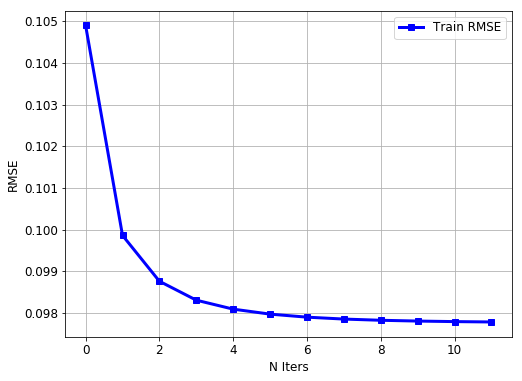

In [17]:
# plot RMSE curve
n_iters = 12

plt.plot(np.arange(n_iters), als.train_RMSE, label='Train RMSE', linewidth=3, color='b', marker='s')
plt.xlabel('N Iters')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

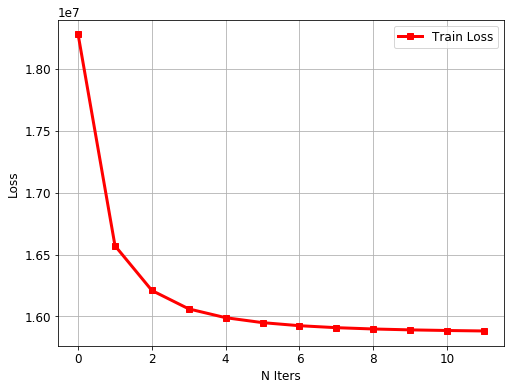

In [18]:
# plot train loss curve
plt.plot(np.arange(n_iters), als.train_loss, label='Train Loss', linewidth=3, color='r', marker='s')
plt.xlabel('N Iters')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Therefore, we may assume `15 iters` is enough for the model to converge.

In [13]:
n_iters = 15
als = ALS_WR(n_factors=20, n_iters=n_iters, alpha=15, _lambda=0.1, seed=1234)
als.fit(X_train)

# Ranking Metrics

1. Mean Average Precision (**MAP**)
2. Hit Ratio (**HR**)
3. Normalized Discounted Cumulative Gain (**NDCG**)
4. ROC/AUC

In [14]:
## Mean Average Precision
# reference: https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision
def AP_k(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0:
        return 0
    
    hit_cnt, precision = 0, 0.0
    for i, p in enumerate(y_pred):
        if p in ground_truth:
            hit_cnt += 1
            precision += hit_cnt / (i + 1.0)

    precision_k = precision / min(len(ground_truth), k)
    return precision_k

def MAP_k(model, ratings, k):
    precision = 0
    n_users = ratings.shape[0]
    
    # for user in tqdm(np.arange(n_users), desc='evaluating...'):
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        precision += AP_k(y_label, y_pred, k)
    
    precision /= n_users
    return precision

In [15]:
## Hit Ratio
def HR_k_helper(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0:
        return 0, 0
    
    hit_cnt = 0
    for p in y_pred:
        if p in ground_truth:
            hit_cnt += 1
    return hit_cnt, len(ground_truth)

def HR_k(model, ratings, k):
    hits, actuals = 0, 0
    n_users = ratings.shape[0]
    
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        
        tmp1, tmp2 = HR_k_helper(y_label, y_pred, k)
        hits += tmp1
        actuals += tmp2
    return hits / actuals

In [16]:
## Normalized Discounted Cummulative Gain
def DCG_k(y_label, y_pred, k):
    ranked = np.argsort(y_pred)[::-1]
    y_label = np.take(y_label, ranked[:k])

    gains = 2 ** y_label - 1
    discounts = np.log2(np.arange(2, gains.size + 2))

    result = np.sum(gains / discounts)
    return result

def NDCG_k_helper(y_label, y_pred, k):
    actual = DCG_k(y_label, y_pred, k)
    best = DCG_k(y_label, y_label, k)
    
    if not best:
        return 0
    return actual / best

def NDCG_k(model, ratings, k):
    result = 0.0
    n_users, n_items = ratings.shape
    
    for user in range(n_users):
        y_label = np.zeros(n_items)
        indices = ratings[user].indices
        y_label[indices] = 1
        u_pred = model._predict_user(user)
        result += NDCG_k_helper(y_label, u_pred, k)
    
    result /= n_users
    return result

In [17]:
## Area Under ROC Curve
def AUC(model, ratings):
    result = 0.0
    n_users, n_items = ratings.shape
    
    for user in np.arange(n_users):
        y_pred = model._predict_user(user)
        y_label = np.zeros(n_items)
        indices = ratings[user].indices
        y_label[indices] = 1
        
        # fix bug about zero division
        # try:
        #     temp = roc_auc_score(y_label, y_pred)
        # except ValueError:
        #     temp = 0.0
        # result += temp

        if len(np.unique(y_label)) == 1:
            result += accuracy_score(y_label, np.rint(y_pred))
        else:
            result += roc_auc_score(y_label, y_pred)
    
    result /= n_users
    return result

In [18]:
## leave-one-out AUC
# def leave_one_out_auc(data, model, n_folds):
#     auc_train_list, auc_validation_list = [], []
    
#     for _ in range(n_folds):
#         # create_train_validation(data, validation_size, seed)
#         X_train, X_validation = create_train_validation(X, 0.2)
#         model.fit(X_train)
        
#         auc_train_list.append(AUC(model, X_train))
#         auc_validation_list.append(AUC(model, X_validation))
    
#     avg_auc_train, avg_auc_validation = np.mean(auc_train_list), np.mean(auc_validation_list)
#     return avg_auc_train, avg_auc_validation

---
# Evaluation
Use 2-weeks validation data `validation.txt` for `model selection`.
First, fix number of latent factors, tune on parameters like `alpha`, `_lambda`.

In [24]:
# select NDCG metric to tune
# als = ALS_WR(n_factors=n_factors, n_iters=n_iters, alpha=15, _lambda=0.1)
n_factors = 20
n_iters = 15
k = 20

for alpha in [1, 10, 20, 40, 80, 100]:
    for _lambda in [0.01, 0.1, 1, 10]:
        model = ALS_WR(n_factors=n_factors, n_iters=n_iters, alpha=alpha, _lambda=_lambda)
        model.fit(X_train)
        
        NDCG_train = NDCG_k(model, X_train, k)
        NDCG_eval = NDCG_k(model, X_validation, k)
        
        print('Model Params: alpha={}, _lambda={}'.format(alpha, _lambda))
        print('NDCG_20 Performance: train={}, eval={}'.format(NDCG_train, NDCG_eval))

Model Params: alpha=1, _lambda=0.01
NDCG_20 Performance: train=0.18857437015951325, eval=0.036477934850654224
Model Params: alpha=1, _lambda=0.1
NDCG_20 Performance: train=0.1877099225579789, eval=0.036161200759844664
Model Params: alpha=1, _lambda=1
NDCG_20 Performance: train=0.1877400595278186, eval=0.036359410066634706
Model Params: alpha=1, _lambda=10
NDCG_20 Performance: train=0.18651714177099823, eval=0.036441166489041395
Model Params: alpha=10, _lambda=0.01
NDCG_20 Performance: train=0.17263141087819256, eval=0.037724698102640154
Model Params: alpha=10, _lambda=0.1
NDCG_20 Performance: train=0.17329440077395825, eval=0.037737291628119826
Model Params: alpha=10, _lambda=1
NDCG_20 Performance: train=0.17309763422171323, eval=0.03789262194100099
Model Params: alpha=10, _lambda=10
NDCG_20 Performance: train=0.1741200410916708, eval=0.03842394421706181
Model Params: alpha=20, _lambda=0.01
NDCG_20 Performance: train=0.15651116349759606, eval=0.036519311347946344
Model Params: alpha=20

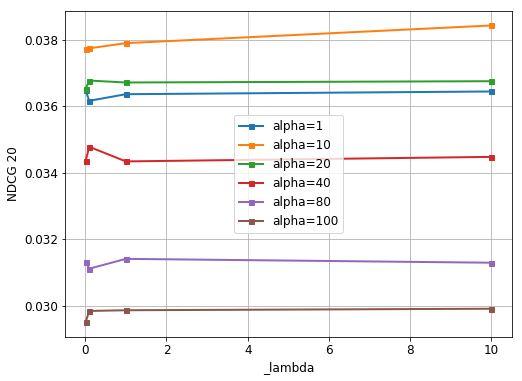

In [22]:
_lambda_list = [0.01, 0.1, 1.0, 10]
alpha_1 = [0.036477934850654224, 0.036161200759844664, 0.036359410066634706, 0.036441166489041395]
alpha_10 = [0.037724698102640154, 0.037737291628119826, 0.03789262194100099, 0.03842394421706181]
alpha_20 = [0.036519311347946344, 0.03676925999487439, 0.03671128958545434, 0.03674975771830592]
alpha_40 = [0.03435889278370445, 0.034779489550210436, 0.03434090660904621, 0.03447711427497447]
alpha_80 = [0.03132535348253008, 0.031118721790370802, 0.03141427507198201, 0.03129840143431755]
alpha_100 = [0.029518477555894602, 0.029849415895201913, 0.029870879657892258, 0.029915979308089976]

plt.plot(_lambda_list, alpha_1, label='alpha=1', linewidth=2, marker='s', MarkerSize=5)
plt.plot(_lambda_list, alpha_10, label='alpha=10', linewidth=2, marker='s', MarkerSize=5)
plt.plot(_lambda_list, alpha_20, label='alpha=20', linewidth=2, marker='s', MarkerSize=5)
plt.plot(_lambda_list, alpha_40, label='alpha=40', linewidth=2, marker='s', MarkerSize=5)
plt.plot(_lambda_list, alpha_80, label='alpha=80', linewidth=2, marker='s', MarkerSize=5)
plt.plot(_lambda_list, alpha_100, label='alpha=100', linewidth=2, marker='s', MarkerSize=5)
plt.xlabel('_lambda')
plt.ylabel('NDCG 20')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Select `_lambda=0.01`, then find suitable value of `alpha` in range(10).

In [31]:
NDCG_20_train, NDCG_40_train, NDCG_60_train = [], [], []
NDCG_20_eval, NDCG_40_eval, NDCG_60_eval = [], [], []

for alpha in np.arange(10):
    model = ALS_WR(n_factors=20, n_iters=15, alpha=alpha, _lambda=0.01)
    model.fit(X_train)
    
    NDCG_20_train_tmp = NDCG_k(model, X_train, 20)
    NDCG_20_eval_tmp = NDCG_k(model, X_validation, 20)
    NDCG_40_train_tmp = NDCG_k(model, X_train, 40)
    NDCG_40_eval_tmp = NDCG_k(model, X_validation, 40)
    NDCG_60_train_tmp = NDCG_k(model, X_train, 60)
    NDCG_60_eval_tmp = NDCG_k(model, X_validation, 60)
    
    NDCG_20_train.append(NDCG_20_train_tmp)
    NDCG_20_eval.append(NDCG_20_eval_tmp)
    NDCG_40_train.append(NDCG_40_train_tmp)
    NDCG_40_eval.append(NDCG_40_eval_tmp)
    NDCG_60_train.append(NDCG_60_train_tmp)
    NDCG_60_eval.append(NDCG_60_eval_tmp)
    
    print('alpha={}'.format(alpha))
    print('Train: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(NDCG_20_train_tmp, NDCG_40_train_tmp, NDCG_60_train_tmp))
    print('Validation: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(NDCG_20_eval_tmp, NDCG_40_eval_tmp, NDCG_60_eval_tmp))

alpha=0
Train: NDCG_20=0.16381917030021934, NDCG_40=0.13250290854805588, NDCG_60=0.13511109336925997
Validation: NDCG_20=0.0310541247996981, NDCG_40=0.03551499466625129, NDCG_60=0.038880827618791476
alpha=1
Train: NDCG_20=0.1882112282019053, NDCG_40=0.15373694354969575, NDCG_60=0.15763251064517206
Validation: NDCG_20=0.03652770936839841, NDCG_40=0.04160828690226829, NDCG_60=0.045480848712512394
alpha=2
Train: NDCG_20=0.19291352300740658, NDCG_40=0.15930685825177074, NDCG_60=0.16380328144513723
Validation: NDCG_20=0.037813161334275855, NDCG_40=0.043144013800986626, NDCG_60=0.047248678648724236
alpha=3
Train: NDCG_20=0.19104310578693098, NDCG_40=0.15986086770483035, NDCG_60=0.1651760809484275
Validation: NDCG_20=0.038153773991776586, NDCG_40=0.043832753890835054, NDCG_60=0.04814254883913996
alpha=4
Train: NDCG_20=0.18815487569289557, NDCG_40=0.1592867896264668, NDCG_60=0.16544980804350168
Validation: NDCG_20=0.03870417321856897, NDCG_40=0.04470602040059592, NDCG_60=0.04909956426588057
al

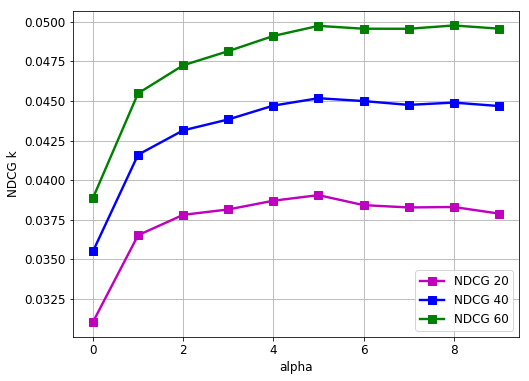

In [27]:
alpha_list = np.arange(10)
NDCG_20_y = [0.0310541247996981, 0.03652770936839841, 0.037813161334275855, 0.038153773991776586, 0.03870417321856897, 0.039057468821816266, 0.038426650333998606, 0.03827951647005845, 0.03830826924126314, 0.037894267179253274]
NDCG_40_y = [0.03551499466625129, 0.04160828690226829, 0.043144013800986626, 0.043832753890835054, 0.04470602040059592, 0.04517166867903848, 0.04499263728059996, 0.044751022141075215, 0.044896415076452, 0.04467865307414587]
NDCG_60_y = [0.038880827618791476, 0.045480848712512394, 0.047248678648724236, 0.04814254883913996, 0.04909956426588057, 0.04973602777668787, 0.049556747197855994, 0.049553363625803905, 0.049761907388890234, 0.04956198759308778]

plt.plot(alpha_list, NDCG_20_y, label='NDCG 20', linewidth=2.4, marker='s', MarkerSize=8, color='m')
plt.plot(alpha_list, NDCG_40_y, label='NDCG 40', linewidth=2.4, marker='s', MarkerSize=8, color='b')
plt.plot(alpha_list, NDCG_60_y, label='NDCG 60', linewidth=2.4, marker='s', MarkerSize=8, color='g')
plt.xlabel('alpha')
plt.ylabel('NDCG k')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Then, fix `alpha=5` and `_lambda=0.01`, tune on number of latent factors.

In [45]:
# select _lambda=0.01 and alpha=5, then find best value of n_factors from 0 to 100
ndcg_20_train, ndcg_40_train, ndcg_60_train = [], [], []
ndcg_20_eval, ndcg_40_eval, ndcg_60_eval = [], [], []

for n_factors in np.arange(5, 105, 5):
    model = ALS_WR(n_factors=n_factors, n_iters=15, alpha=5, _lambda=0.01)
    model.fit(X_train)

    ndcg_20_train_tmp = NDCG_k(model, X_train, 20)
    ndcg_20_eval_tmp = NDCG_k(model, X_validation, 20)
    ndcg_40_train_tmp = NDCG_k(model, X_train, 40)
    ndcg_40_eval_tmp = NDCG_k(model, X_validation, 40)
    ndcg_60_train_tmp = NDCG_k(model, X_train, 60)
    ndcg_60_eval_tmp = NDCG_k(model, X_validation, 60)
    
    ndcg_20_train.append(ndcg_20_train_tmp)
    ndcg_20_eval.append(ndcg_20_eval_tmp)
    ndcg_40_train.append(ndcg_40_train_tmp)
    ndcg_40_eval.append(ndcg_40_eval_tmp)
    ndcg_60_train.append(ndcg_60_train_tmp)
    ndcg_60_eval.append(ndcg_60_eval_tmp)
    
    print('n_factors={}'.format(n_factors))
    print('Train: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(ndcg_20_train_tmp, ndcg_40_train_tmp, ndcg_60_train_tmp))
    print('Validation: NDCG_20={}, NDCG_40={}, NDCG_60={}'.format(ndcg_20_eval_tmp, ndcg_40_eval_tmp, ndcg_60_eval_tmp))

n_factors=5
Train: NDCG_20=0.10025339175160762, NDCG_40=0.0883921285276951, NDCG_60=0.09380894693161969
Validation: NDCG_20=0.026611282152815614, NDCG_40=0.031319428830007795, NDCG_60=0.03496952332810884
n_factors=10
Train: NDCG_20=0.1353477219411973, NDCG_40=0.11806116104020838, NDCG_60=0.12417732125848434
Validation: NDCG_20=0.03285694257331715, NDCG_40=0.03856182026900365, NDCG_60=0.04267757223204715
n_factors=15
Train: NDCG_20=0.16218159167031704, NDCG_40=0.13949812086516422, NDCG_60=0.14607088218629313
Validation: NDCG_20=0.03643735158810433, NDCG_40=0.0422955912854181, NDCG_60=0.046688430862310955
n_factors=20
Train: NDCG_20=0.18492090159765598, NDCG_40=0.15775829465193283, NDCG_60=0.16448028685731728
Validation: NDCG_20=0.03824840641125516, NDCG_40=0.04453193593290615, NDCG_60=0.049107216526652404
n_factors=25
Train: NDCG_20=0.20640461061466248, NDCG_40=0.17508139830074654, NDCG_60=0.18171470035711734
Validation: NDCG_20=0.04094742652449327, NDCG_40=0.04738625984747453, NDCG_60=

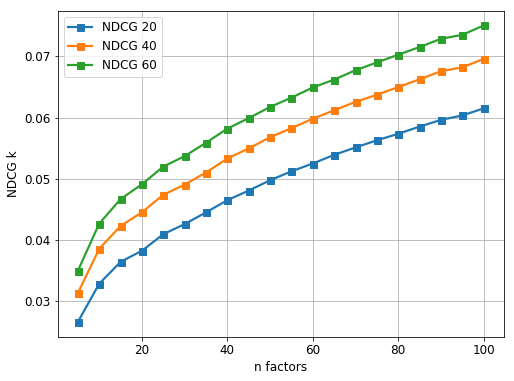

In [25]:
n_factors_list = np.arange(5, 105, 5)
ndcg_20_vali_ = [0.026611282152815614, 0.03285694257331715, 0.03643735158810433, 0.03824840641125516, 0.04094742652449327, 0.04260455449106625, 0.04451421451893097, 0.04651254689747523, 0.048079246107899744, 0.04976603498203971, 0.05122224772200222, 0.05250142935616977, 0.053912051406399084, 0.05512040462893318, 0.05629118921445083, 0.05735173677948426, 0.0585321483172142, 0.05962883674218879, 0.06035410906245225, 0.06150373364820475]
ndcg_40_vali_ = [0.031319428830007795, 0.03856182026900365, 0.0422955912854181, 0.04453193593290615, 0.04738625984747453, 0.04905382499946623, 0.051026337078734524, 0.05332268916995871, 0.05496188382300554, 0.05679093118628377, 0.05827577007826263, 0.059815126665688105, 0.061199596495029984, 0.06257099473010529, 0.06372761231348195, 0.06499138185097184, 0.06625794590892713, 0.06757347748247865, 0.06821357511679957, 0.06959400932611913]
ndcg_60_vali_ = [0.03496952332810884, 0.04267757223204715, 0.046688430862310955, 0.049107216526652404, 0.05199799630666944, 0.053700654780967076, 0.05588854400256422, 0.05819884895845833, 0.05990839979314753, 0.06173849571752975, 0.06325784428547523, 0.0649209698247753, 0.06620969344161984, 0.06773622638844011, 0.06900536575552867, 0.07027798665993339, 0.07153023259576295, 0.07287250944744718, 0.07352520128844835, 0.07505270638295669]

plt.plot(n_factors_list, ndcg_20_vali_, label='NDCG 20', linewidth=2.2, marker='s', MarkerSize=7)
plt.plot(n_factors_list, ndcg_40_vali_, label='NDCG 40', linewidth=2.2, marker='s', MarkerSize=7)
plt.plot(n_factors_list, ndcg_60_vali_, label='NDCG 60', linewidth=2.2, marker='s', MarkerSize=7)
plt.xlabel('n factors')
plt.ylabel('NDCG k')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Extend scale to 0~400, and select `n_factors=20` for test, consider computation cost and avoid over-fitting.

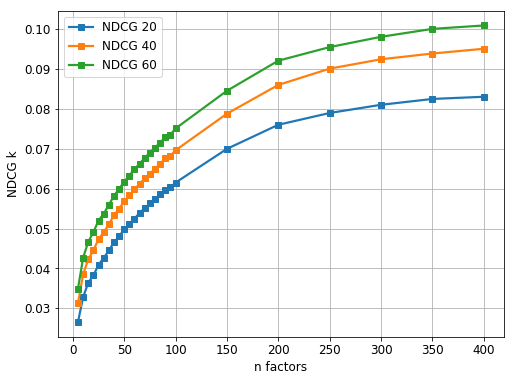

In [26]:
n_factors_list = list(range(5, 105, 5)) + [150, 200, 250, 300, 350, 400]
ndcg_20_vali_ = [0.026611282152815614, 0.03285694257331715, 0.03643735158810433, 0.03824840641125516, 0.04094742652449327, 0.04260455449106625, 0.04451421451893097, 0.04651254689747523, 0.048079246107899744, 0.04976603498203971, 0.05122224772200222, 0.05250142935616977, 0.053912051406399084, 0.05512040462893318, 0.05629118921445083, 0.05735173677948426, 0.0585321483172142, 0.05962883674218879, 0.06035410906245225, 0.06150373364820475, 0.06994785818992093, 0.07597969214361855, 0.07892787458006274, 0.08097873752252215, 0.0824387314361851, 0.082987445105373]
ndcg_40_vali_ = [0.031319428830007795, 0.03856182026900365, 0.0422955912854181, 0.04453193593290615, 0.04738625984747453, 0.04905382499946623, 0.051026337078734524, 0.05332268916995871, 0.05496188382300554, 0.05679093118628377, 0.05827577007826263, 0.059815126665688105, 0.061199596495029984, 0.06257099473010529, 0.06372761231348195, 0.06499138185097184, 0.06625794590892713, 0.06757347748247865, 0.06821357511679957, 0.06959400932611913, 0.07875073731085334, 0.08594945980211445, 0.09002507689255349, 0.0923719286935762, 0.0938119289175349, 0.095001737144873]
ndcg_60_vali_ = [0.03496952332810884, 0.04267757223204715, 0.046688430862310955, 0.049107216526652404, 0.05199799630666944, 0.053700654780967076, 0.05588854400256422, 0.05819884895845833, 0.05990839979314753, 0.06173849571752975, 0.06325784428547523, 0.0649209698247753, 0.06620969344161984, 0.06773622638844011, 0.06900536575552867, 0.07027798665993339, 0.07153023259576295, 0.07287250944744718, 0.07352520128844835, 0.07505270638295669, 0.08448573441820706, 0.09201862517844989, 0.09541986060236975, 0.09799673899324319, 0.0999786560746988, 0.100833643107855]

plt.plot(n_factors_list, ndcg_20_vali_, label='NDCG 20', linewidth=2.2, marker='s')
plt.plot(n_factors_list, ndcg_40_vali_, label='NDCG 40', linewidth=2.2, marker='s')
plt.plot(n_factors_list, ndcg_60_vali_, label='NDCG 60', linewidth=2.2, marker='s')
plt.xlabel('n factors')
plt.ylabel('NDCG k')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

---

Try training on `normalized` frequency dataset. Here, run model on `processed_train_2.txt`, `processed_validation_2.txt` and `processed_test_2.txt`.

In [20]:
# load dataset
df_2 = pd.read_csv('../Data/processed_train_2.txt', sep='\t', header=None, names=['userId', 'itemId', 'rating'])
X_train_2, df_2 = create_matrix(df_2, 'userId', 'itemId', 'rating')

df_v_2 = pd.read_csv('../Data/processed_validation_2.txt', sep='\t', header=None, names=['userId', 'itemId', 'rating'])
X_validation_2, df_v_2 = create_validation_test_matrix(df_v_2, 'userId', 'itemId', 'rating', N, M)

df_t_2 = pd.read_csv('../Data/processed_test_2.txt', sep='\t', header=None, names=['userId', 'itemId', 'rating'])
X_test_2, df_t_2 = create_validation_test_matrix(df_t_2, 'userId', 'itemId', 'rating', N, M)

In [21]:
X_train_2, X_validation_2, X_test_2

(<34619x47880 sparse matrix of type '<class 'numpy.float64'>'
 	with 1180452 stored elements in Compressed Sparse Row format>,
 <34619x47880 sparse matrix of type '<class 'numpy.float64'>'
 	with 234524 stored elements in Compressed Sparse Row format>,
 <34619x47880 sparse matrix of type '<class 'numpy.float64'>'
 	with 125816 stored elements in Compressed Sparse Row format>)

Repeat previous steps of evaluation on 0/1 dataset, suppose `_lambda=0.01, n_factors=20`, and tune on `alpha`.

In [161]:
alpha_list = np.arange(0, 91, 5)
ndcg_20_train, ndcg_20_eval = [], []

for alpha in alpha_list:
    model = ALS_WR(n_factors=20, n_iters=12, alpha=alpha, _lambda=0.01)
    model.fit(X_train_2)
    
    NDCG_20_train_tmp = NDCG_k(model, X_train_2, 20)
    NDCG_20_eval_tmp = NDCG_k(model, X_validation_2, 20)
    ndcg_20_train.append(NDCG_20_train_tmp)
    ndcg_20_eval.append(NDCG_20_eval_tmp)
    
    print('alpha={}'.format(alpha))
    print('Train: NDCG_20={}, Validation: NDCG_20={}'.format(NDCG_20_train_tmp, NDCG_20_eval_tmp))

alpha=0
Train: NDCG_20=0.16279999520054592, Validation: NDCG_20=0.030875043001116875
alpha=5
Train: NDCG_20=0.17086852838314445, Validation: NDCG_20=0.0328644103949911
alpha=10
Train: NDCG_20=0.1755621087972071, Validation: NDCG_20=0.03507741198152595
alpha=15
Train: NDCG_20=0.17977708112078872, Validation: NDCG_20=0.03640306561165743
alpha=20
Train: NDCG_20=0.18404649526265582, Validation: NDCG_20=0.037744736900226124
alpha=25
Train: NDCG_20=0.18713543443284877, Validation: NDCG_20=0.03867724984109405
alpha=30
Train: NDCG_20=0.18714129896384057, Validation: NDCG_20=0.03899015339353276
alpha=35
Train: NDCG_20=0.18980874414333745, Validation: NDCG_20=0.03990904184229883
alpha=40
Train: NDCG_20=0.1902756217795297, Validation: NDCG_20=0.040132676114212486
alpha=45
Train: NDCG_20=0.19252168037136105, Validation: NDCG_20=0.04128802612032425
alpha=50
Train: NDCG_20=0.1921412227091168, Validation: NDCG_20=0.04084880669547041
alpha=55
Train: NDCG_20=0.1919139045277137, Validation: NDCG_20=0.04

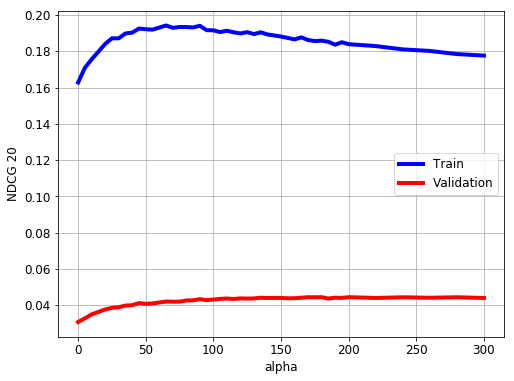

In [36]:
alpha_list = np.append(np.arange(0, 201, 5), np.arange(220, 301, 20))
ndcg_20_train = [0.16279999520054592, 0.17086852838314445, 0.1755621087972071, 0.17977708112078872, 0.18404649526265582, 0.18713543443284877, 0.18714129896384057, 0.18980874414333745, 0.1902756217795297, 0.19252168037136105, 0.1921412227091168, 0.1919139045277137, 0.19303086670542022, 0.194219269516192, 0.192912079255555, 0.1933821487225367, 0.19332891520429413, 0.1931532783464922, 0.19405388808404891, 0.19163709270627632, 0.1915493853031622, 0.1905623932828189, 0.19131263516997488, 0.1904479211628923, 0.1898232303161896, 0.19055077343480564, 0.18945208102982114, 0.19046802984559907, 0.1892590609980256, 0.18871411819698436, 0.18813059757424075, 0.18736096880360376, 0.1865256025347011, 0.1876798612313722, 0.18619163770211236, 0.18562272715399777, 0.18584429321817972, 0.1852237612052908, 0.1836177272255679, 0.18497418755588724, 0.18390863412309952, 0.1828708524938825, 0.18103704012409016, 0.1801857087941328, 0.1784698534753355, 0.17762358994977143]
ndcg_20_eval = [0.030875043001116875, 0.0328644103949911, 0.03507741198152595, 0.03640306561165743, 0.037744736900226124, 0.03867724984109405, 0.03899015339353276, 0.03990904184229883, 0.040132676114212486, 0.04128802612032425, 0.04084880669547041, 0.04108674047842606, 0.04162152678676545, 0.04212405798278878, 0.04205647561032901, 0.04206179318488652, 0.04271742175134776, 0.04275741327685144, 0.04344917397050383, 0.04288548688920219, 0.04322698075139682, 0.04359542198614361, 0.04380560584943232, 0.04353919301298931, 0.04387303092388086, 0.04375441909851612, 0.04384539293718649, 0.04422436247282588, 0.0440822994353165, 0.044145756952323194, 0.044082538820047944, 0.04393092209275813, 0.04395494067168186, 0.044235519688007346, 0.04450976849265156, 0.044499901231477235, 0.044538864986624085, 0.04377354432797759, 0.04425185413058353, 0.04413140517126637, 0.044538348969107085, 0.04411168531663256, 0.04447389211931677, 0.04421360038104901, 0.04448697653139347, 0.04409498731451862]

plt.plot(alpha_list, ndcg_20_train, label='Train', linewidth=4, color='b')
plt.plot(alpha_list, ndcg_20_eval, label='Validation', linewidth=4, color='r')
plt.xlabel('alpha')
plt.ylabel('NDCG 20')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Based on evaluation on `processed_validation.txt` and `processed_validation_2.txt`, we can conclude for 0/1 dataset and normalized frequency dataset, the key difference for tuning paramaters lie in the `alpha` value. (`alpha=5` for `als`, `alpha=50` for `als_2`) For the `_lambda` and `n_factors`, they have little influence on the `NDCG` performance.

---
# Test
Use 1-week transaction data `test.txt` for test, consider time dependency of recommendation model.

In [143]:
# Re-train model use train+validation data
train_dict = defaultdict(lambda : defaultdict(int))
file_path_1, file_path_2 = '../train.txt', '../validation.txt'

with open(file_path_1, 'r') as f1:
    for line in f1.readlines():
        line = line.split()
        user, item = line[0], line[4]
        if user in train_user_map and item in train_item_map:
            user_id, item_id = train_user_map[user], train_item_map[item]
            # train_dict[user_id][item_id] = 1
            train_dict[user_id][item_id] += 1

with open(file_path_2, 'r') as f2:
    for line in f2.readlines():
        line = line.split()
        user, item = line[0], line[4]
        if user in train_user_map and item in train_item_map:
            user_id, item_id = train_user_map[user], train_item_map[item]
            # train_dict[user_id][item_id] = 1
            train_dict[user_id][item_id] += 1

# if normalize
for uid in train_dict:
    tmp = sum(train_dict[uid].values())
    for iid in train_dict[uid]:
        train_dict[uid][iid] /= tmp

# write re-train file
# with open('../retrain.txt', 'w') as h:
with open('../retrain_2.txt', 'w') as h:
    for uid in sorted(train_dict):
        for iid in sorted(train_dict[uid]):
            h.write("{}\t{}\t{}\n".format(uid, iid, train_dict[uid][iid]))
            
# re-train shape same as (N, M)
print('re-train density: {:.4f}%'.format(100 * sum(len(train_dict[u].keys()) for u in train_dict) / (N * M)))

re-train density: 0.0813%


In [22]:
# read re-train
file_rt_path = '../Data/retrain.txt'
df_rt = pd.read_csv(file_rt_path, sep='\t', header=None, names=['userId', 'itemId', 'rating'])

X_retrain, df_rt = create_validation_test_matrix(df_rt, 'userId', 'itemId', 'rating', N, M)
X_retrain

<34619x47880 sparse matrix of type '<class 'numpy.int64'>'
	with 1347335 stored elements in Compressed Sparse Row format>

Test the performance of mentioned ranking metrics for selected model (`Model 1`), where `n_factors=20, n_iters=15, alpha=5, _lambda=0.01`.

In [59]:
# re-train model
als = ALS_WR(n_factors=20, n_iters=15, alpha=5, _lambda=0.01)
als.fit(X_retrain)

Test on `top-k` ranking metrics performance with the increasing of `k`.

In [145]:
k_list = np.arange(10, 90, 10)
NDCG_train, MAP_train, HR_train = [], [], []
NDCG_eval, MAP_eval, HR_eval = [], [], []
NDCG_test, MAP_test, HR_test = [], [], []

for k in k_list:
    NDCG_train_tmp = NDCG_k(als, X_train, k)
    MAP_train_tmp = MAP_k(als, X_train, k)
    HR_train_tmp = HR_k(als, X_train, k)
    NDCG_validation_tmp = NDCG_k(als, X_validation, k)
    MAP_validation_tmp = MAP_k(als, X_validation, k)
    HR_validation_tmp = HR_k(als, X_validation, k)
    NDCG_test_tmp = NDCG_k(als, X_test, k)
    MAP_test_tmp = MAP_k(als, X_test, k)
    HR_test_tmp = HR_k(als, X_test, k)
    
    NDCG_train.append(NDCG_train_tmp)
    MAP_train.append(MAP_train_tmp)
    HR_train.append(HR_train_tmp)
    NDCG_eval.append(NDCG_validation_tmp)
    MAP_eval.append(MAP_validation_tmp)
    HR_eval.append(HR_validation_tmp)
    NDCG_test.append(NDCG_test_tmp)
    MAP_test.append(MAP_test_tmp)
    HR_test.append(HR_test_tmp)
    
    print('top-{} performance:'.format(k))
    print('NDCG@{}: train={}, validation={}, test={}'.format(k, NDCG_train_tmp, NDCG_validation_tmp, NDCG_test_tmp))
    print('MAP@{}: train={}, validation={}, test={}'.format(k, MAP_train_tmp, MAP_validation_tmp, MAP_test_tmp))
    print('HR@{}: train={}, validation={}, test={}'.format(k, HR_train_tmp, HR_validation_tmp, HR_test_tmp))

top-10 performance:
NDCG@10: train=0.21830913436536367, validation=0.05553963816665074, test=0.023035772125022815
MAP@10: train=0.10902624509442836, validation=0.026512018911679782, test=0.011291170687002899
HR@10: train=0.05198940744731679, validation=0.05545701079633641, test=0.03922394607998983
top-20 performance:
NDCG@20: train=0.17394753204545016, validation=0.05807861460606039, test=0.025668150702952953
MAP@20: train=0.06853186374413126, validation=0.024732387991627115, test=0.011281709498280178
HR@20: train=0.07588195030378195, validation=0.0809170916409408, test=0.05843453932727157
top-30 performance:
NDCG@30: train=0.15495546984188882, validation=0.062386081593285375, test=0.028125405404699017
MAP@30: train=0.05412264251507391, validation=0.025226806096640096, test=0.011642229571187102
HR@30: train=0.0936708989437944, validation=0.09937575685217717, test=0.07287626375023844
top-40 performance:
NDCG@40: train=0.15008472539667356, validation=0.06619202449618761, test=0.030251292

---

Besides, we should do test on model trained from normalized frequency dataset `retrain_2.txt` and compare the results. Test on the second model (`Model 2`), where `n_factors=20, n_iters=15, alpha=50, _lambda=0.01`.

In [23]:
df_rt_2 = pd.read_csv('../Data/retrain_2.txt', sep='\t', header=None, names=['userId', 'itemId', 'rating'])

X_retrain_2, df_rt_2 = create_validation_test_matrix(df_rt_2, 'userId', 'itemId', 'rating', N, M)
X_retrain_2

<34619x47880 sparse matrix of type '<class 'numpy.float64'>'
	with 1347335 stored elements in Compressed Sparse Row format>

In [56]:
als_2 = ALS_WR(n_factors=20, n_iters=15, alpha=50, _lambda=0.01)
als_2.fit(X_retrain_2)

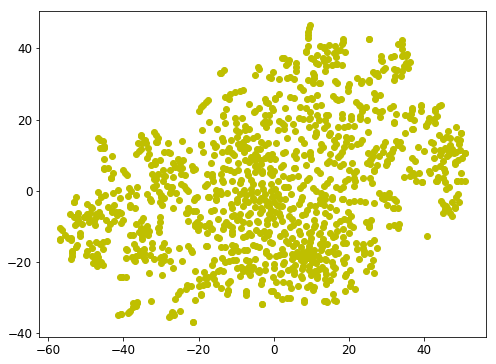

In [124]:
# visualize using t-SNE
sampled = random.sample(list(als_2.item_factors), 1200)
X_user_factors = TSNE(n_components=2, perplexity=20, init='pca', random_state=0).fit_transform(sampled)
plt.scatter(X_user_factors[:,0], X_user_factors[:,1], color='y')

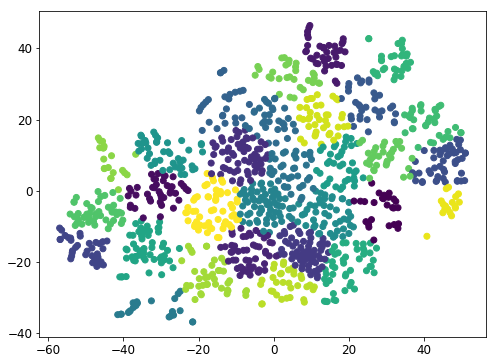

In [125]:
# k-means to check separability
kmeans = KMeans(n_clusters=30, random_state=0)
kmeans.fit(X_user_factors)
plt.scatter(X_user_factors[:,0], X_user_factors[:,1], c=kmeans.labels_)
plt.show()
plt.close()

In [192]:
k_list = np.arange(10, 90, 10)
ndcg_train, map_train, hr_train = [], [], []
ndcg_test, map_test, hr_test = [], [], []

for k in k_list:
    ndcg_train_tmp = NDCG_k(als_2, X_retrain_2, k)
    map_train_tmp = MAP_k(als_2, X_retrain_2, k)
    hr_train_tmp = HR_k(als_2, X_retrain_2, k)
    ndcg_test_tmp = NDCG_k(als_2, X_test_2, k)
    map_test_tmp = MAP_k(als_2, X_test_2, k)
    hr_test_tmp = HR_k(als_2, X_test_2, k)
    
    ndcg_train.append(ndcg_train_tmp)
    map_train.append(map_train_tmp)
    hr_train.append(hr_train_tmp)
    ndcg_test.append(ndcg_test_tmp)
    map_test.append(map_test_tmp)
    hr_test.append(hr_test_tmp)
    
    print('top-{} performance:'.format(k))
    print('NDCG@{}: retrain={}, test={}'.format(k, ndcg_train_tmp, ndcg_test_tmp))
    print('MAP@{}: retrain={}, test={}'.format(k, map_train_tmp, map_test_tmp))
    print('HR@{}: retrain={}, test={}'.format(k, hr_train_tmp, hr_test_tmp))

top-10 performance:
NDCG@10: retrain=0.2708924238157674, test=0.0258112930751295
MAP@10: retrain=0.15009306957064858, test=0.013168246563383697
HR@10: retrain=0.05126861545198484, test=0.04108380492147263
top-20 performance:
NDCG@20: retrain=0.20492218162279952, test=0.027932208255642348
MAP@20: retrain=0.08994496116044869, test=0.013007368620834132
HR@20: retrain=0.0693012502458557, test=0.058076874165447955
top-30 performance:
NDCG@30: retrain=0.1763852979463582, test=0.03024926095932075
MAP@30: retrain=0.06845180035923575, test=0.013338275152661344
HR@30: retrain=0.08289623590272649, test=0.07127074457938577
top-40 performance:
NDCG@40: retrain=0.16423178880483774, test=0.03209358643890342
MAP@40: retrain=0.059526598536246395, test=0.013584138886558088
HR@40: retrain=0.09409241205787722, test=0.08188147771348636
top-50 performance:
NDCG@50: retrain=0.1618367757254141, test=0.033715876784973925
MAP@50: retrain=0.056572731087657736, test=0.013781416721680201
HR@50: retrain=0.103885076

### NDCG@*k*

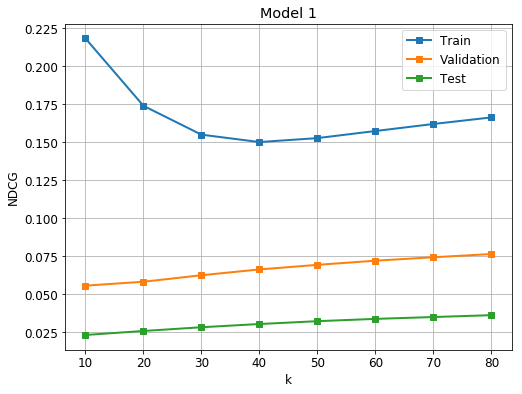

In [193]:
plt.plot(k_list, NDCG_train, label='Train', linewidth=2, marker='s')
plt.plot(k_list, NDCG_eval, label='Validation', linewidth=2, marker='s')
plt.plot(k_list, NDCG_test, label='Test', linewidth=2, marker='s')
plt.title('Model 1')
plt.xlabel('k')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

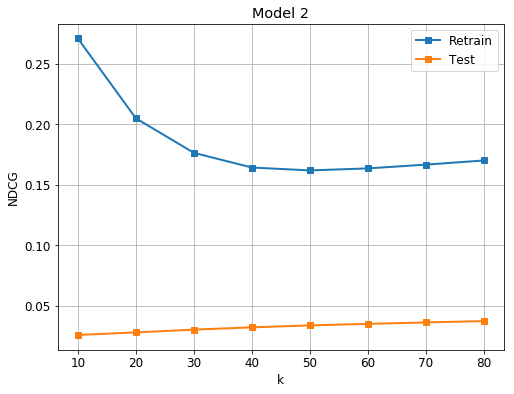

In [199]:
plt.plot(k_list, ndcg_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, ndcg_test, label='Test', linewidth=2, marker='s')
plt.title('Model 2')
plt.xlabel('k')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

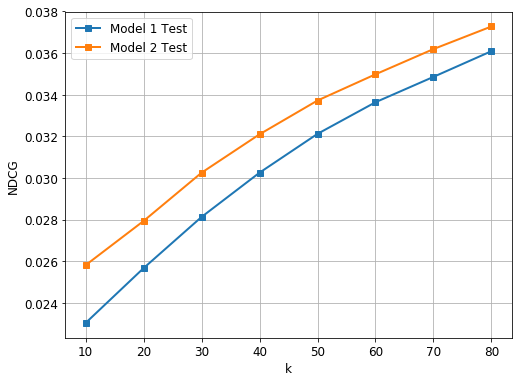

In [197]:
# compare
plt.plot(k_list, NDCG_test, label='Model 1 Test', linewidth=2, marker='s')
plt.plot(k_list, ndcg_test, label='Model 2 Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

### MAP@*k*

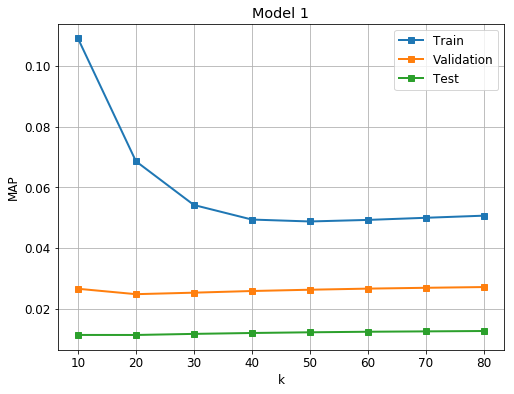

In [198]:
plt.plot(k_list, MAP_train, label='Train', linewidth=2, marker='s')
plt.plot(k_list, MAP_eval, label='Validation', linewidth=2, marker='s')
plt.plot(k_list, MAP_test, label='Test', linewidth=2, marker='s')
plt.title('Model 1')
plt.xlabel('k')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

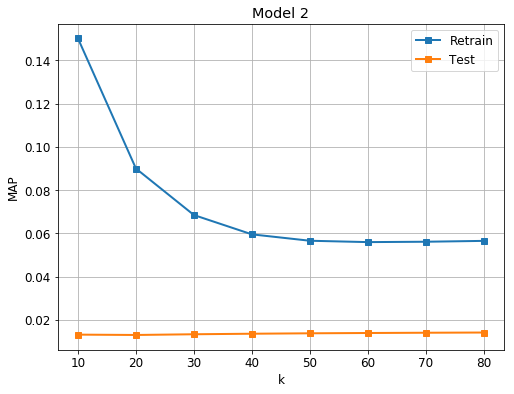

In [201]:
plt.plot(k_list, map_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, map_test, label='Test', linewidth=2, marker='s')
plt.title('Model 2')
plt.xlabel('k')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

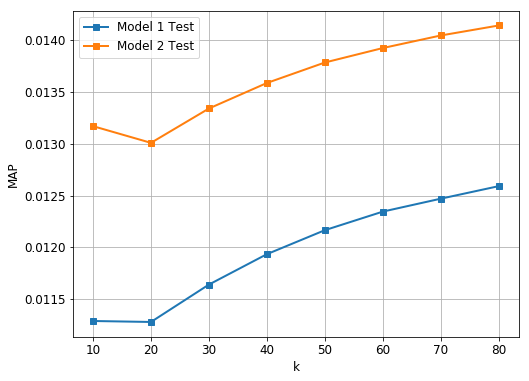

In [204]:
# compare
plt.plot(k_list, MAP_test, label='Model 1 Test', linewidth=2, marker='s')
plt.plot(k_list, map_test, label='Model 2 Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

### HR@*k*

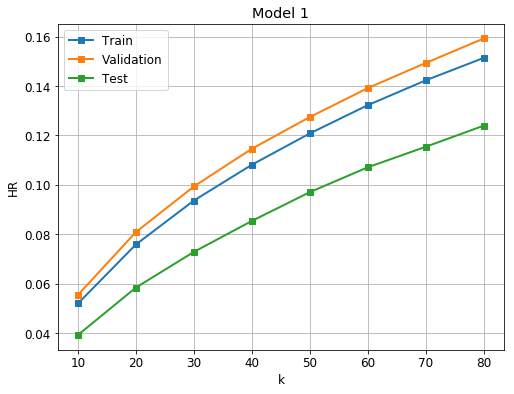

In [205]:
plt.plot(k_list, HR_train, label='Train', linewidth=2, marker='s')
plt.plot(k_list, HR_eval, label='Validation', linewidth=2, marker='s')
plt.plot(k_list, HR_test, label='Test', linewidth=2, marker='s')
plt.title('Model 1')
plt.xlabel('k')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

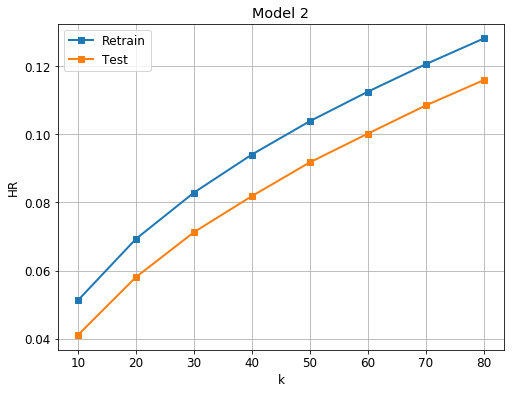

In [206]:
plt.plot(k_list, hr_train, label='Retrain', linewidth=2, marker='s')
plt.plot(k_list, hr_test, label='Test', linewidth=2, marker='s')
plt.title('Model 2')
plt.xlabel('k')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

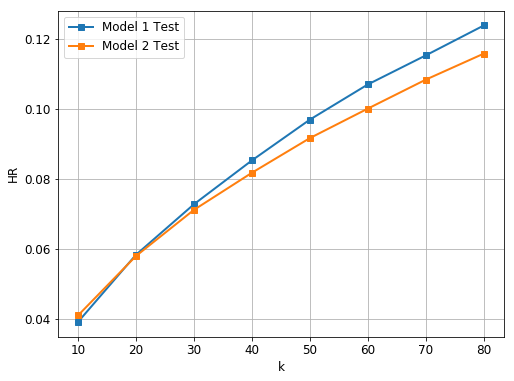

In [207]:
# compare
plt.plot(k_list, HR_test, label='Model 1 Test', linewidth=2, marker='s')
plt.plot(k_list, hr_test, label='Model 2 Test', linewidth=2, marker='s')
plt.xlabel('k')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

Compare the two models from different preprocessing methods, we find that the second model fitting the normalized frequency dataset outperforms the first one in NDCG and MAP metrics (close in HR). Therefore, we choose the **`Model 2`** as the best recommender model in this project.

---
# Prediction

Finally, we should put our model into real application, to recommend top K items for specified customers. The dataflow shows as: `cid -> user_id -> item_id -> catalog_item_id`. The relevant mappings are stored in the `preprocess.ipynb`.

In [40]:
%store -r cid_map
%store -r catalog_item_id_map

N, M = len(cid_map), len(catalog_item_id_map)
N, M

(34209, 47857)

In [57]:
best_model = als_2
# ALS_WR(n_factors=20, n_iters=15, alpha=50, _lambda=0.01)

In [60]:
best_model.predict()

array([[ 7.86327420e-02,  6.59229205e-03, -6.95473826e-03, ...,
         4.59756037e-04,  1.23667126e-03,  6.32775669e-05],
       [ 1.02945337e-02, -5.38506984e-04,  4.29230730e-03, ...,
         4.08080167e-05,  4.45156650e-04, -8.73961267e-05],
       [ 3.87880180e-03, -1.77502193e-03,  1.95808551e-02, ...,
        -1.58425987e-04,  1.28617032e-04,  1.17703863e-03],
       ...,
       [ 2.35044359e-02,  4.05963048e-03,  3.69313466e-03, ...,
         1.08323958e-04,  1.30451173e-03, -3.43465095e-04],
       [ 2.43214317e-02,  3.62297268e-03, -6.93960416e-04, ...,
         6.12703290e-05,  6.80932167e-04, -1.44471938e-04],
       [-1.55792882e-03, -1.09970445e-03, -3.55530041e-03, ...,
        -1.02198153e-04,  1.78357476e-04,  4.41065239e-05]])

In [59]:
n_samples = 5
sampled_users = np.random.choice(list(train_user_map.keys()), n_samples)
sampled_users

array(['ad082399f3c546ccb21c22ed549ca908',
       'f05077c5608c0cfee044001517f43a86',
       '7b581a751de24fd48020fe151edd3f2b',
       'c17b06ffbbfd438da3ba75e618a74eff',
       '6c80ba0e97e44015abce52d19453b1f1'], dtype='<U32')

In [61]:
sampled_user_ids = list(map(lambda x:train_user_map.get(x), sampled_users))
sampled_user_ids

[27025, 27943, 10784, 19260, 34192]

In [62]:
u_pred = list(map(lambda x:best_model._predict_user(x), sampled_user_ids))
u_pred

[array([ 1.01719669e-02,  3.60657485e-03, -2.99276033e-03, ...,
         2.77277119e-04,  4.38569391e-04, -1.10487980e-05]),
 array([ 1.45310122e-02,  4.23077234e-03, -3.95643086e-03, ...,
        -1.49881329e-05, -4.68337495e-04, -1.54533824e-04]),
 array([ 0.00068774,  0.00194209, -0.00438604, ..., -0.00010888,
         0.00049327,  0.00010026]),
 array([-1.57191467e-03,  2.14015385e-03,  4.16461935e-03, ...,
        -4.65668046e-05,  2.39155913e-04,  7.78708037e-04]),
 array([ 8.22059592e-03,  2.88740897e-03,  4.98499559e-03, ...,
         4.94201192e-05, -6.68882750e-05,  2.10762710e-04])]

In [63]:
# recommend 6 items for each sampled user
K = 6
y_pred = list(map(lambda x:np.argsort(x)[::-1][:K], u_pred))
y_pred

[array([ 137, 1567,  714, 1467,  226,  693]),
 array([ 309,  992,  215,  305, 2026,  273]),
 array([  535,  2051, 17703,  2415,   748,  1704]),
 array([2649,  215,  726, 2026, 4622, 3738]),
 array([4254, 1455, 9539, 6690, 1983, 1660])]

In [64]:
y_pred_output = list(list(map(lambda x:catalog_item_id_map.get(x), user_vec)) for user_vec in y_pred)
y_pred_output

[['530562791', '11984481', '893466615', '43431716', '17034374', '46701589'],
 ['274092761', '22063035', '184903489', '722217997', '711347883', '578843475'],
 ['514661633', '52196241', '23636896', '153202890', '540480044', '28985853'],
 ['38045189', '184903489', '14150586', '711347883', '52538273', '415665424'],
 ['52658651', '49065767', '32802019', '55374804', '17173948', '44923256']]

---
Test the output of my defined methods `_recommend_user`, `recommend` and `_similar_items` in the `ALS_WR` class.

In [65]:
best_model._recommend_user(6753, N=6)  # 'f0760cb6eeb034cce044001517f43a86'

[305, 594, 386, 1062, 992, 436]

In [66]:
best_model.recommend(sampled_user_ids, N=6)  # same as the previous test

array([[  137,  1567,   714,  1467,   226,   693],
       [  309,   992,   215,   305,  2026,   273],
       [  535,  2051, 17703,  2415,   748,  1704],
       [ 2649,   215,   726,  2026,  4622,  3738],
       [ 4254,  1455,  9539,  6690,  1983,  1660]])

In [67]:
sampled_items = np.random.choice(list(train_item_map.keys()), n_samples)
sampled_items

array(['16879847', '653330322', '10322221', '24797654', '53834652'],
      dtype='<U10')

In [68]:
sampled_item_ids = list(map(lambda x:train_item_map.get(x), sampled_items))
sampled_item_ids

[11940, 17210, 22782, 21439, 46809]

In [69]:
best_model._similar_items(sampled_item_ids, N=5)

array([[14287, 21535,  5768,  1448,  9261],
       [20512, 12668,   249,  7587,  4939],
       [42478, 47871, 33527, 22274, 44058],
       [30214, 24232, 35489,  5927, 17440],
       [19244, 34813,  5583, 40392, 26451]])

# Case Study

Select a sample user, use our model to recommend top N items based on the purchase history. And visualize the outputs from the item page on Walmart.com.

In [ ]:
# test user: '7b581a751de24fd48020fe151edd3f2b'
# train_dict['7b581a751de24fd48020fe151edd3f2b']
defaultdict(<class 'int'>, {
    '762509212': 2, 
    '10307700': 1, 
    '610627633': 2, 
    '20606796': 1, 
    '162433676': 2, 
    '127471323': 1, 
    '14018038': 1, 
    '331157650': 1, 
    '23619931': 1, 
    '25065575': 2, 
    '45612361': 1, 
    '27231189': 1, 
    '33963183': 2, 
    '151835792': 1, 
    '835076821': 2, 
    '723575351': 1, 
    '165253444': 1, 
    '19635718': 1, 
    '24360609': 1, 
    '14150016': 1, 
    '38453308': 1, 
    '35756520': 1, 
    '49527355': 1, 
    '55630914': 1, 
    '52459941': 1, 
    '327970267': 1, 
    '15783126': 1, 
    '14089586': 1, 
    '127722938': 1, 
    '49333136': 1})

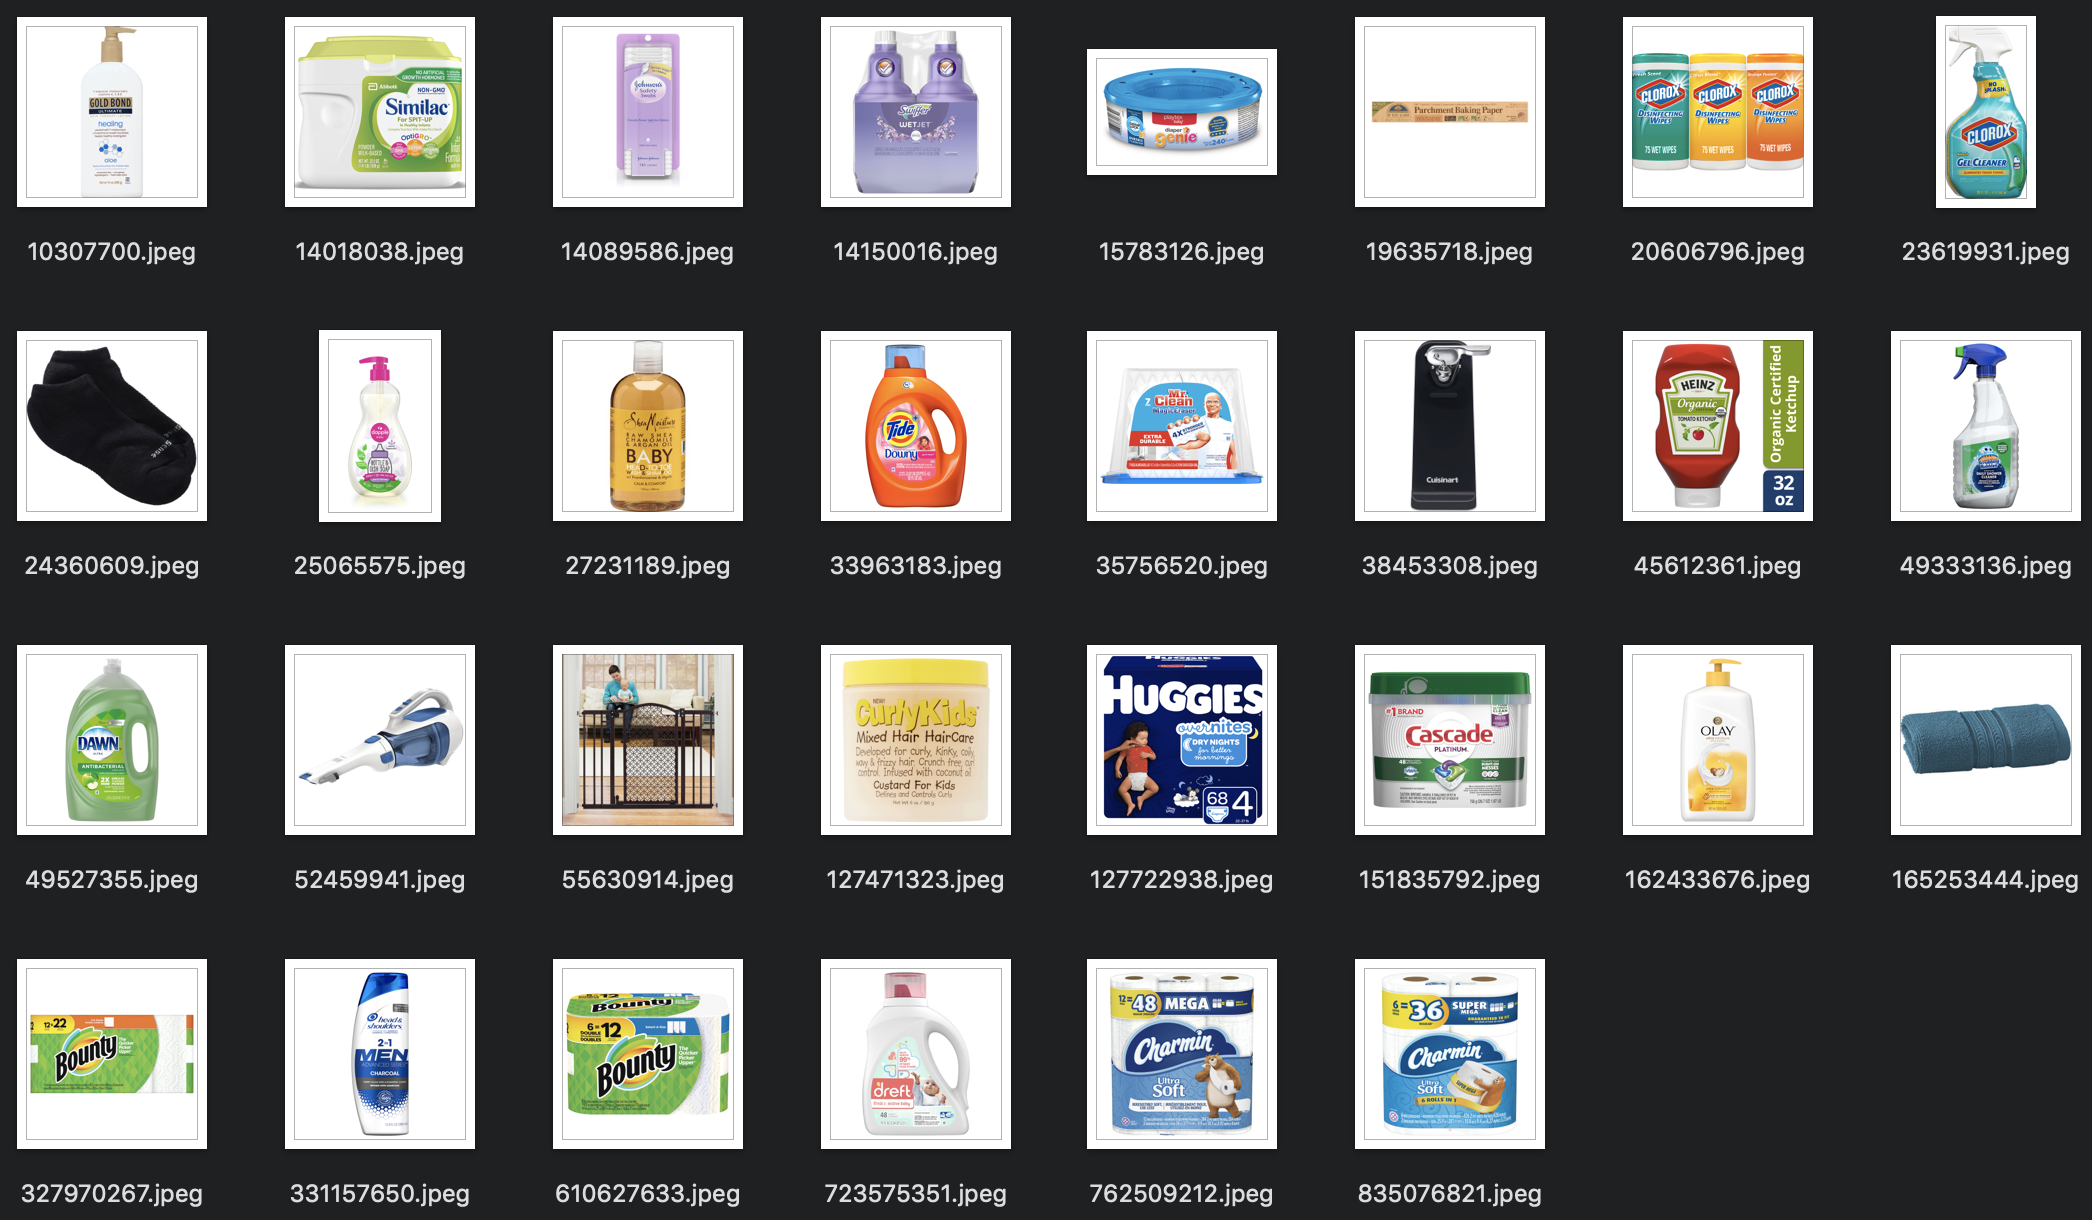

In [133]:
user_id = train_user_map['7b581a751de24fd48020fe151edd3f2b']
user_id

10784

In [130]:
# top-8 recommendation
rec_idx = best_model._recommend_user(user_id, N=10)
rec_idx

[535, 2051, 17703, 2415, 748, 1704, 4451, 2312, 2059, 847]

In [131]:
rec_itemid = list(map(lambda x:catalog_item_id_map.get(x), rec_idx))
rec_itemid

['514661633',
 '52196241',
 '23636896',
 '153202890',
 '540480044',
 '28985853',
 '10419062',
 '14504328',
 '401199665',
 '520738534']

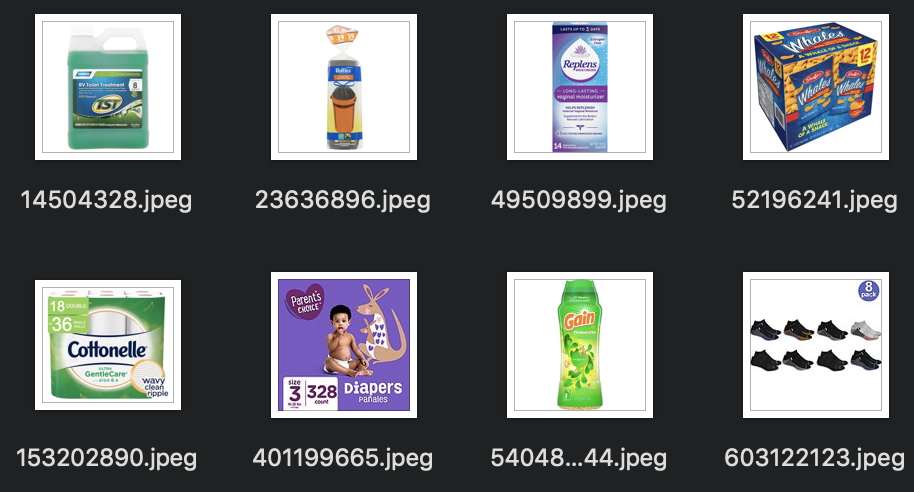

In [123]:
# find similar items for given one
# sample item: 401199665
item_id = train_item_map['14018038']
item_id

3703

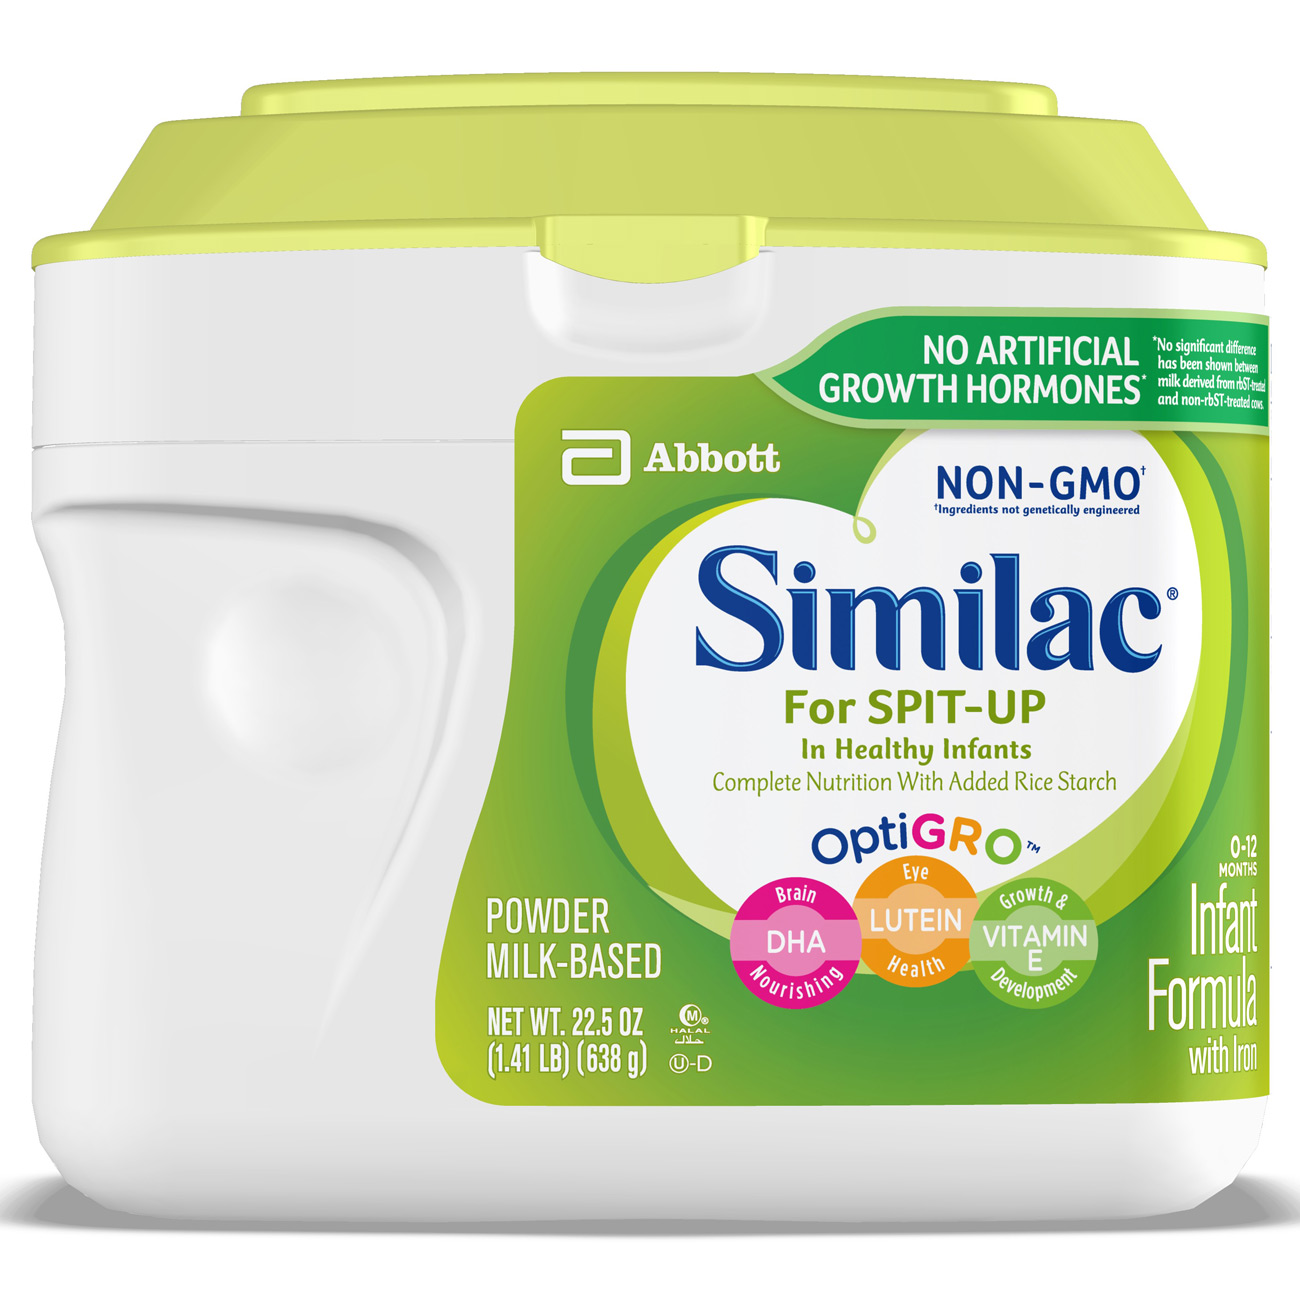

In [128]:
simi_idx = best_model._similar_items([item_id], N=10)  # return 2D-array
simi_idx[0]

array([27265,  8275, 39482,  5741,  3153, 35367, 45420, 12641, 44190,
       38460])

In [129]:
simi_itemid = list(map(lambda x:catalog_item_id_map.get(x), simi_idx[0]))
simi_itemid

['55139724',
 '929828867',
 '46291110',
 '36326463',
 '10824297',
 '148537714',
 '828775963',
 '10451063',
 '278392073',
 '21896576']

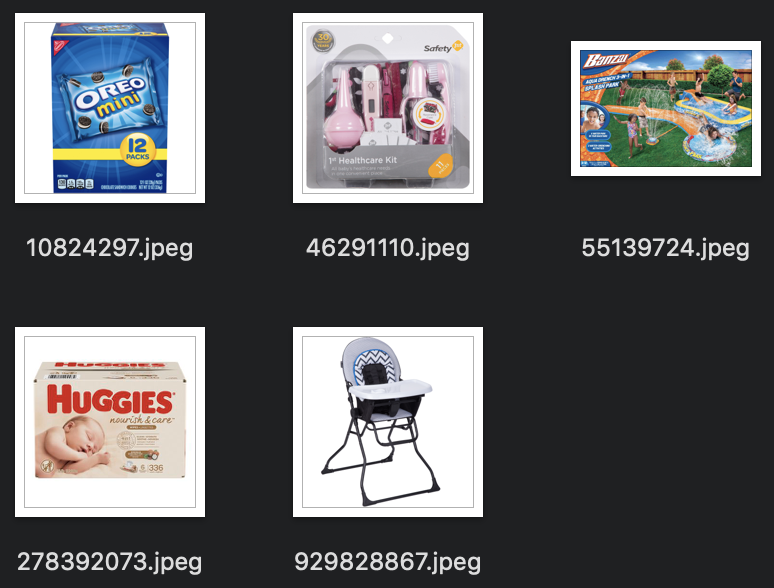

# Reference
1. [Collaborative Filtering for Implicit Feedback Datasets](http://yifanhu.net/PUB/cf.pdf)
2. [Matrix Factorization Techniques for Recommender Systems](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)